# Matching PWS rates information from 2017 CA-NV AWWA report with PWSid

The 2017 CA-NV AWWA reports contains information about rates charged by about 300 WSPs, but it did not include the PWSID. The `name` field of the tables with PWS information, in most cases, does not match exactly with the `provider_name` in the AWWA rates table.

This is a common situation when dealing with real world data. One possible solution is to perform a "fuzzy match join": the two tables are compared, a (fuzzy) string matching algorithm applied to each `(left_name, right_name)` combination, and the highest score is taken for the tentative match. The algorithm returns a single continuous score, but below a certain threshold (empirically, 0.5), a high number of false negatives (missed matches, usually because of abbreviations) occurs, as well as false positives (when the string matching algorithm scores high because of long, non-identifying common parts of the name such as `XXX Municipal Water Company` and `YYY Municipal Water Company`).

The choice of algorithm, parameter optimization, ect. is interesting in its own regard, but for time constraints I decided to opt for a preliminary pass with an automated algorithm, and then a manual/visual check on a spreadsheet, choosing among a set of match quality markers to indentify the match and then selecting only matches above a certain threshold to include in further processing.

In [1]:
# %load nb-imports.py
import geopandas as gpd
import pandas as pd
import numpy as np

import cawc
from cawc import datasets as ds

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
RATES = ds.PWS_RATES()[['provider_name', 'total_charge']]

[dataset `pws-rates-awwa`]: getting from loader...
[dataset `pws-rates-awwa`]: processing...


In [3]:
ID = ds.PWS_BOUNDARIES()[['pwsid', 'name', 'county_fips']]

[dataset `pws-boundaries`]: getting from loader...
[dataset `pws-boundaries`]: processing...


I tried to study both `join` possibilities separately; in the end, without a more thorough study, I opted to continue with `JOIN_2` since it's a better match for our intent (of all possible PWSIDs, we want to have as many matched rate charges as possible).

In [4]:
import fuzzymatcher as fm

JOIN_1 = fm.fuzzy_left_join(RATES, ID, left_on='provider_name', right_on='name')
JOIN_2 = fm.fuzzy_left_join(ID, RATES, left_on='name', right_on='provider_name')

In [5]:
JOIN_1.loc[lambda d: d.best_match_score > 0.1]

,best_match_score,__id_left,__id_right,provider_name,total_charge,pwsid,name,county_fips
0,0.660616,0_left,1997_right,Alameda County Water District,62.66,CA0110001,ALAMEDA COUNTY WATER DISTRICT,1
1,0.243397,1_left,2373_right,Amador Water Agency,45.72,CA3310005,DESERT WATER AGENCY,65
7,0.637465,2_left,2238_right,American Canyon City Of,55.63,CA2810005,"AMERICAN CANYON, CITY OF",55
8,0.526898,3_left,1218_right,Anaheim City Of,18.16,CA3010001,CITY OF ANAHEIM,59
9,0.670879,4_left,4291_right,Antioch City Of,53.72,CA0710001,CITY OF ANTIOCH,13
26,0.493564,6_left,3244_right,Arcadia City Of,42.69,CA1910003,CITY OF ARCADIA,37
27,0.503599,7_left,4517_right,Arcata City Of,26.25,CA1210001,"ARCATA, CITY OF",23
30,0.161438,9_left,2120_right,Arroyo Grande City Of,70.94,CA4010001,"ARROYO GRANDE, WATER DEPARTMENT",79
90,0.506829,10_left,696_right,Bakersfield City Of,32.83,CA1510031,"BAKERSFIELD, CITY OF",29
91,0.771279,11_left,2214_right,Bear State Water Works,18.77,CA0901217,BEAR STATE WATER WORKS,17


In [6]:
JOIN_2.loc[lambda d: d.best_match_score > 0.2]

,best_match_score,__id_left,__id_right,pwsid,name,county_fips,provider_name,total_charge
729,0.388590,51_left,134_right,CA3710010,HELIX WATER DISTRICT,73,Helix Water District,64.25
999,0.462648,69_left,244_right,CA3010036,CITY OF SAN CLEMENTE,59,San Clemente City Of,54.47
1054,0.439750,71_left,104_right,CA3010069,CITY OF FOUNTAIN VALLEY,59,Fountain Valley City Of,33.24
1234,0.227250,80_left,250_right,CA1910039,SAN GABRIEL VALLEY WATER CO.-EL MONTE,37,San Gabriel Valley Water Company,62.20
1237,0.295424,81_left,222_right,CA3710016,RAINBOW MUNICIPAL WD,73,Rainbow Municipal Water District,133.90
1366,0.450837,94_left,138_right,CA4110016,TOWN OF HILLSBOROUGH,81,Hillsborough Town Of,241.20
1641,0.231470,106_left,267_right,CA5400536,KINGS RIVER ESTATES MUTUAL WATER COMPANY,107,Sierra Estates Mutual Water Company,69.59
1834,0.341550,114_left,132_right,CA0110006,CITY OF HAYWARD,1,Hayward City Of,49.22
2006,0.305135,123_left,122_right,CA3010035,GOLDEN STATE WC - PLACENTIA,59,Golden State Water Company Placentia,64.15
2040,0.331516,127_left,72_right,CA3310037,"CORONA, CITY OF",65,Corona City Of,52.72


In [7]:
JOIN_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4746 entries, 0 to 76438
Data columns (total 8 columns):
best_match_score    3361 non-null float64
__id_left           4746 non-null object
__id_right          3361 non-null object
pwsid               4746 non-null object
name                4746 non-null object
county_fips         4746 non-null int64
provider_name       3361 non-null category
total_charge        3361 non-null float64
dtypes: category(1), float64(2), int64(1), object(4)
memory usage: 318.4+ KB


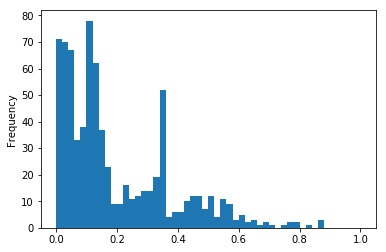

In [8]:
JOIN_2.best_match_score.plot.hist(range=(0, 1), bins=50)

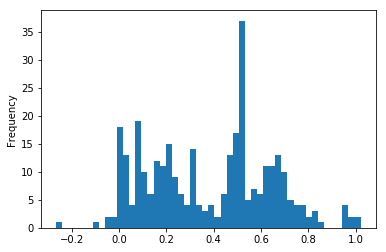

In [9]:
JOIN_1.best_match_score.plot.hist(bins=50)

In [10]:
JOIN_2.to_csv('pws-matching-1.csv')

In [87]:
ds.PWS_RATES().to_csv('pws-awwa-1.csv')

[dataset `pws-rates-awwa`]: getting from loader...
[dataset `pws-rates-awwa`]: processing...


In [11]:
RATES.set_index('provider_name')

,total_charge
provider_name,
Alameda County Water District,62.66
Amador Water Agency,45.72
American Canyon City Of,55.63
Anaheim City Of,18.16
Antioch City Of,53.72
Apple Valley Ranchos Water Company,97.87
Arcadia City Of,42.69
Arcata City Of,26.25
Arrowbear Park County Water District,86.00


In [90]:
def get_index_diff(df1, df2):
    return df2.index.difference(df1.index)

def get_with_fewest_nulls(df, source_columns=None):
    return df[source_columns].bfill(axis=1).iloc[:, 0]

def apply_corrections(df):
    from functools import partial

    return df.assign(provider_name=partial(get_with_fewest_nulls, source_columns=['match_corrected', 'provider_name']))

def process_rates_match(df):
    return (df
            .pipe(apply_corrections)
#             .assign()
           )

Here we perfom a three-way match between the AWWA rates table and the PWS table, using the match table as an intermediate. The `PWS.RATES_MATCH` dataset is loaded from the corrected table, exported as a CSV file from an Airtable base after manual inspection and processing.

A slighly modified version of this operation is included in the TODO:fill dataset.

In [95]:
(ds.PWS.RATES_MATCH()
 .pipe(apply_corrections)
 .set_index('provider_name')
 .join(ds.PWS_RATES().set_index('provider_name')[['total_charge']], how='left')
 .reset_index(drop=False).set_index('pwsid')
 [['provider_name', 'best_match_score', 'quality', 'total_charge']]
 .rename(columns={'provider_name': 'name_awwa2017',
                  'best_match_score': 'name_match_score',
                  'quality': 'name_match_quality',
                 })
 .join(ds.PWS_BOUNDARIES().set_index('pwsid')[['name', 'area_km2']], how='right')
 [['name', 'name_awwa2017', 'name_match_score', 'name_match_quality', 'area_km2', 'total_charge']]
#  .dropna(subset=['name'])
 .sort_index()
 .sort_values('area_km2', ascending=False)
)

[dataset `pws-rates-match-2`]: getting from loader...
[dataset `pws-rates-match-2`]: processing...
[dataset `pws-rates-awwa`]: getting from loader...
[dataset `pws-rates-awwa`]: processing...
[dataset `pws-boundaries`]: getting from loader...
[dataset `pws-boundaries`]: processing...


,name,name_awwa2017,name_match_score,name_match_quality,area_km2,total_charge
pwsid,,,,,,
CA1910087,METROPOLITAN WATER DIST. OF SO. CAL.,NaN,NaN,NaN,13625.885494,NaN
CA1310014,IMPERIAL IRRIGATION DISTRICT,NaN,NaN,NaN,2466.149873,NaN
CA3310001,COACHELLA VWD: COVE COMMUNITY,NaN,NaN,NaN,1910.107177,NaN
CA3310009,EASTERN MUNICIPAL WD,NaN,NaN,NaN,1436.033699,NaN
CA3310049,WESTERN MWD,Western Municipal Water District,0.07945,match,1342.762986,70.44
CA1910067,"LOS ANGELES-CITY, DEPT. OF WATER & POWER",Los Angeles Department Of Water And Power,0.41962,match,1284.632781,45.68
CA4310027,SANTA CLARA VALLEY WATER DISTRICT,NaN,NaN,NaN,1119.086752,NaN
CA0110010,ZONE 7 WATER AGENCY,NaN,NaN,NaN,1116.671117,NaN
CA0110005,EAST BAY MUD,East Bay Municipal Utility District,0.00226,match,1052.861384,51.31
